핸즈온 머신러닝 3장 분류 p.127-154

In [1]:
#matplotlib 한글 깨짐 방지
#이 셀 먼저 돌리고 런타임 재실행
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (9,077 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [1]:
#경고 무시
import warnings
warnings.filterwarnings('ignore')

#matplotlib 한글 깨짐 방지
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

## 3.1 MNIST

In [2]:
# MNIST 데이터 다운
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)
# 이미지 7000개, 784개(28*28 픽셀)의 특성
# 0(흰색)~255(검은색)까지의 픽셀 강도

(70000, 784)
(70000,)


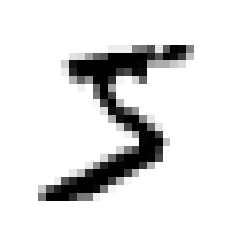

5


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
some_digit=X.to_numpy()[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

print(y[0])

In [5]:
# 레이블은 문자열이므로 정수 변환
y = y.astype(np.uint8)

In [6]:
# 훈련 세트와 테스트 데이터 세트 분리
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 훈련

In [7]:
# 5-감지기(이진 분류기): 5와 5 아님 2개의 클래스로 분류 
y_train_5 = (y_train ==5)
y_test_5 = (y_test == 5)

In [10]:
# SGDClassifier 클래스: 확률적 경사 하강법(SGD) 분류기
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit]) # 분류기는 이 이미지가 5를 나타낸다고 추측함(True)

array([ True])

## 3.3 성능 측정

- 교차 검증

Stratified KFold: 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링 수행. 매 반복에서 분류기 객체를 복제하여 훈련 폴드를 훈련시키고 테스트 폴드로 예측. 올바른 예측수를 세어 정확한 예측의 비율을 출력

In [ ]:
# 교차 검증: cross_val_score()
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train.values[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train.values[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [ ]:
# cross_val_score(): k-겹 교차 검증은 훈련 세트를 k개의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델 사용
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
# 모든 이미지를 5 아님 클래스로 분류하는 더미 분류기 만들기
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1),dtype='bool')

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')
# 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측하면 정확도가 0.9
# 정확도를 분류기의 성능 측정 지표로 선호X (특히, 불균형한 데이터셋을 다룰 때)

array([0.91125, 0.90855, 0.90915])

## 3.3.2 오차 행렬

- cross_val_predict(): k-겹 교차 검증을 수행하지만 각 테스트 폴드에서 얻은 예측을 반환

- confusion_matrix(): 행은 실제 클래스, 열은 예측한 클래스

In [12]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
# 완벽한 분류기일 경우
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

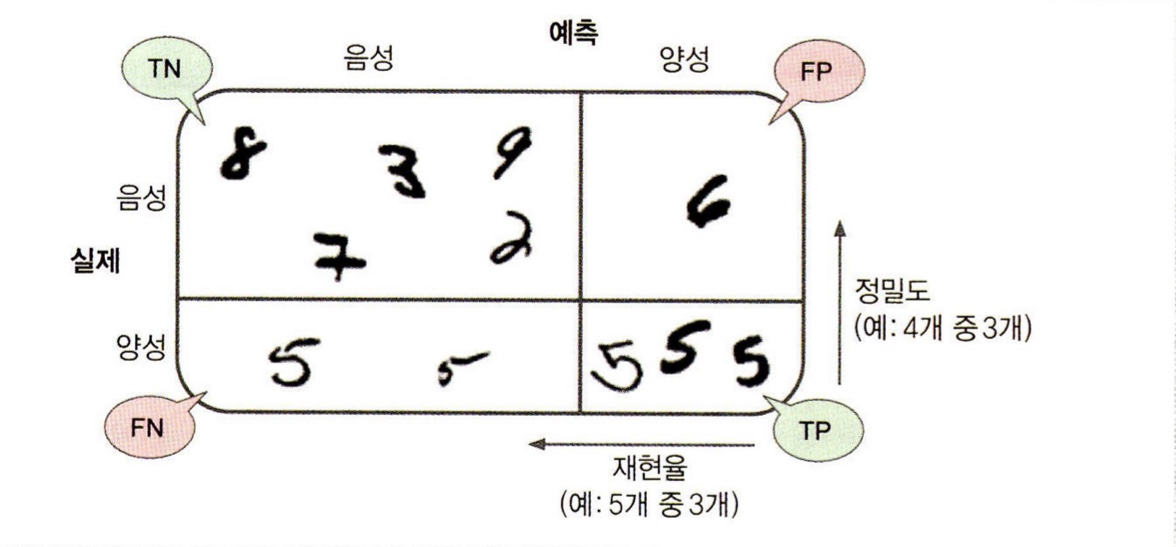

## 3.3.3 정밀도와 재현율

In [ ]:
from sklearn.metrics import precision_score, recall_score
# 정밀도
print(precision_score(y_train_5, y_train_pred)) # 5로 판별된 이미지 중 83.7%만 정확
# 재현율
print(recall_score(y_train_5, y_train_pred)) # 전체 숫자 5 중에서 65%만 감지

0.8370879772350012
0.6511713705958311


In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred) # 정밀도와 재현율이 비슷한 분류기에서 f1점수가 높음.

0.7325171197343846

## 3.3.4 정밀도/재현율 트레이드오프

- **정밀도/재현율 트레이드오프**: 정밀도를 올리면 재현율이 줄고 재현율을 올리면 정밀도가 낮아짐.

- 정밀도 = P(실제 양성l양성 판정)

- 재현율 = P(양성 판정l실제 양성)

임곗값이 높을수록 재현율은 낮아지고 정밀도는 높아짐. 

In [ ]:
# decision_function(): 각 샘플의 점수를 알려줌. 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만듬
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores>threshold)

In [ ]:
y_some_digit_pred

array([ True])

In [ ]:
# 임곗값을 높임 - 재현율 감소
threshold = 8000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

In [ ]:
# 적절한 임곗값 정하기 - cross_val_predict() 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해 결정 점수를 반환 받음.
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [ ]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

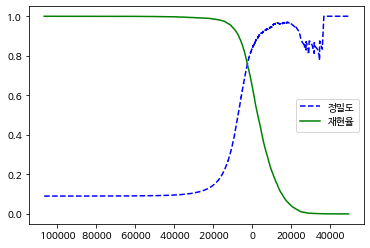

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label='정밀도')
  plt.plot(thresholds, recalls[:-1], "g-", label="재현율")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.legend()
plt.show()
# 정밀도는 임곗값을 올리면 일반적으로 증가하지만, 낮아질 수도 있음. 
# 재현율은 임곗값이 올라감에 따라 줄어듬.

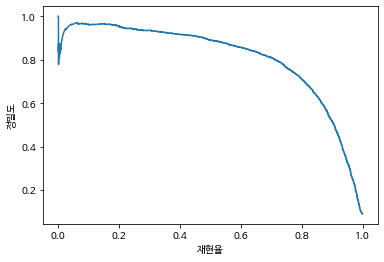

In [ ]:
# 좋은 정밀도/재현율 트레이드오프 선택 - 재현율에 대한 정밀도 곡선 그리기
plt.plot(recalls, precisions)
plt.xlabel('재현율')
plt.ylabel('정밀도')
plt.show()
# 재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작함. 하강점 직전을 정밀도/재현율 트레이드오프로 선택

In [ ]:
# 정밀도 90% 달성이 목표라면,
# np.argmax(): 최댓값의 첫 번째 인덱스 반환
threshold_90_precision = thresholds[np.argmax(precisions>=0.9)]

In [ ]:
threshold_90_precision

3370.019499143958

In [ ]:
# 훈련 세트에 대한 예측
y_train_pred_90 = (y_scores>=threshold_90_precision)

In [ ]:
# 정밀도 - 90% 달성
print(precision_score(y_train_5, y_train_pred_90))
# 재현율
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


## 3.3.5 ROC 곡선

- ROC 곡선: 거짓 양성 비율에 대한 진짜 양성 비율(민감도에 대한 1-특이도 그래프)

- 일반적으로 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 FR곡선을 사용하고, 그렇제 않으면 ROC곡선 사용

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

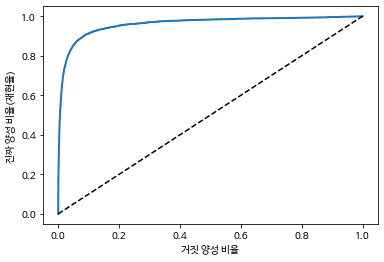

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1],'k--') # 좋은 분류기는 이 점선에서 최대한 멀리 떨어져야 함.

plot_roc_curve(fpr, tpr)
plt.xlabel('거짓 양성 비율')
plt.ylabel('진짜 양성 비율(재현율)')
plt.show()

In [ ]:
# 곡선 아래의 면적(AUC)을 측정하여 분류기 비교
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [ ]:
# RandomForestClassifier에는 decision_function() 메서드가 없고 predict_proba() 메서드가 있음.
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [ ]:
# roc_curve() 함수는 레이블과 점수를 기대하지만, 점수 대신에 양성 클래스에 대한 확률을 점수로 사용
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

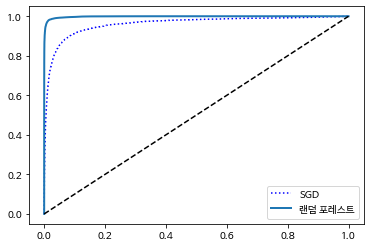

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc='lower right')
plt.show()
# 랜덤포레스트 분류기가 SGD분류기보다 좋음.

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## 3.4 다중 분류

- SGD 분류기, 랜덤 포레스트 분류기, 나이브 베이즈 분류기 등 일부 알고리즘은 여러 개의 클래스를 직접 처리할 수 있지만, 로지스틱 회귀나 서포트 벡터 머신 분류기 등 다른 알고리즘은 이진 분류만 가능 -> 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많음.특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만듬.

  ex) OvR(OvA)전략: 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 택함. 

  ex) OvO전략: 0과 1 구별, 0과 2 구별, 1과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시키는 기법. 클래스가 n개라면 분류기는 n(n-1)/2개가 필요함. 분류기 모두를 통과시켜 가장 많이 양성으로 분류된 클래스를 선택함. 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것이 장점.

  -> SVM 등 일부 알고리즘은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO를 더 선호함. 

  -> 대부분의 이진 분류 알고리즘에서는 OvR을 선호함.

  -> 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행함.

In [ ]:
# 5를 구별한 y_train_5 대신 0~9까지의 y_train을 이용해 SVC를 훈련시킴. 
# OvO 전략을 사용해 10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택함.
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

In [ ]:
# 클래스마다 점수
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores # 가장 높은 점수가 클래스 5에 해당하는 값임.

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_ # 타깃 클래스의 리스트

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

In [ ]:
# 사이킷런에서 OvO나 OvR을 사용하도록 하려면 OneVsOneClassifier 또는 OneVsRestClassifier 사용
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
# SGDClassifier 훈련시키기 
# SGD분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 OvO나 OvR을 적용X
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
# decision_function(): 클래스마다 하나의 값을 반환 - 5에서 점수가 가장 높음.
sgd_clf.decision_function([some_digit])

In [ ]:
# SGDClassifier의 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

In [20]:
# 입력의 스케일을 조정하여 성능을 더 높임.
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석

- 오차 행렬 살펴보기: cross_val_predict() 함수를 사용해 예측을 만들고 confusion_matrix() 함수 호출

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [22]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

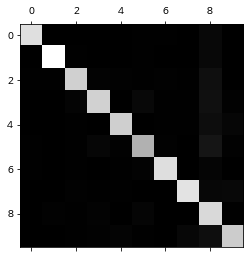

In [23]:
# 오차행렬을 이미지로 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()
# 오차행렬은 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋음. 
# 숫자 5는 다른 숫자보다 조금 어두움. - 숫자5의 이미지가 적거나 분류기가 숫자5를 다른 숫자만큼 잘 분류하지 못한다는 뜻

In [ ]:
# 오차행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

In [ ]:
norm_conf_mx

array([[9.41583657e-01, 0.00000000e+00, 3.71433395e-03, 8.44166807e-04,
        1.35066689e-03, 7.25983454e-03, 6.07800101e-03, 1.01300017e-03,
        3.79875063e-02, 1.68833361e-04],
       [0.00000000e+00, 9.49273213e-01, 5.48798576e-03, 3.55977455e-03,
        5.93295758e-04, 6.52625334e-03, 5.93295758e-04, 1.03826758e-03,
        3.14446752e-02, 1.48323939e-03],
       [4.53172205e-03, 4.53172205e-03, 8.76132931e-01, 1.54414233e-02,
        1.22524337e-02, 4.53172205e-03, 1.12453844e-02, 6.04229607e-03,
        6.34441088e-02, 1.84625713e-03],
       [3.58832164e-03, 2.77279400e-03, 1.90833469e-02, 8.52552602e-01,
        3.26211059e-04, 3.31104224e-02, 4.40384929e-03, 6.52422117e-03,
        6.57315283e-02, 1.19067036e-02],
       [2.05409106e-03, 2.39643958e-03, 7.01814447e-03, 1.54056830e-03,
        8.87024991e-01, 2.05409106e-03, 5.81992468e-03, 4.62170490e-03,
        5.93974666e-02, 2.80725779e-02],
       [4.98063088e-03, 2.76701716e-03, 5.53403431e-03, 3.09905921e-02,
   

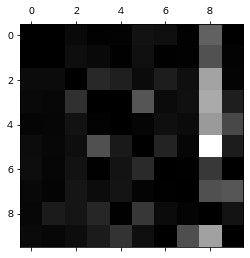

In [ ]:
# 주대각선만 0으로 채워서 그래프 그리기
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- 행은 실제 클래스, 열은 예측한 클래스
- 클래스 8의 열이 상당히 밝아 많은 이미지가 8로 잘못 분류됨을 암시
 
-> 8로 잘못 분류되는 것을 줄이도록 개선해야 함. 

-> 8처럼 보이는 숫자의 훈련 데이터를 더 많이 모아 실제 8과 구분하도록 분류기를 학습시켜야 함. 

-> 또는 분류기에 도움 될만한 특성을 더 찾아볼 수 있음. ex. 동심원의 수 세기(8은 2개, 6은 1개, 5는 0개) 

-> 또는 동심원 같은 어떤 패턴이 드러나도록 이미지를 전처리해볼 수 있음. (Scikit-Image, Pillow, OpenCV 등)

In [24]:
# 3과 5의 샘플을 그려보기
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a)&(y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a)&(y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b)&(y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b)&(y_train_pred == cl_b)]

In [25]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
   # **options = 가변 키워드 인수(얼마든지 많은 옵션을 포함할 수 있음)
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

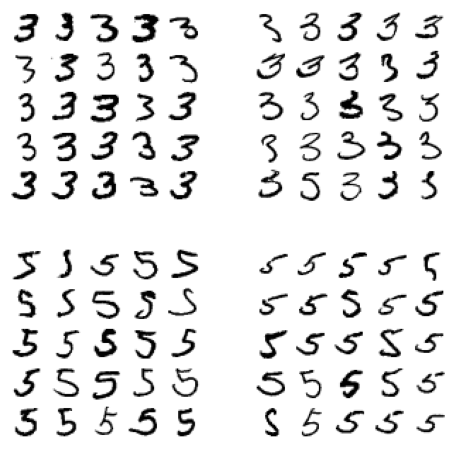

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

- 분류기에서 에러 발생 원인: 선형 모델인 SGDClassifier를 사용했기 때문. 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산함. 따라서, 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 됨. 

- 3과 5의 주요 차이는 위쪽 선과 아래쪽 호를 이어주는 작은 직선의 위치. 숫자 3을 쓸 떄 연결 부위가 조금 왼쪽으로 치우치면 분류기가 5로 분류하고, 또 반대도 마찬가지. 즉, 분류기는 이미지의 위치나 회전 방향에 매우 민감함. 

- 3과 5의 에러를 줄이는 하나의 방법은 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하는 것

## 3.6 다중 레이블 분류

- 다중 레이블 분류: 여러 개의 이진 꼬리표를 출력하는 분류 시스템 ex. 얼굴 인식 시스템

In [27]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train>=7)
y_train_odd = (y_train%2==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [28]:
knn_clf.predict([some_digit])
# 5는 7보다 크지 않고(False), 홀수(True)

array([[False,  True]])

In [29]:
# 다중 레이블 분류기 평가하기 - 모든 레이블에 대한 f1점수의 평균 계산
from sklearn.metrics import f1_score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')
# 모든 레이블의 가중치가 같다고 가정
# 특정 레이블이 많다면 레이블에 클래스의 지지도를 가중치로 줌 (average="weighted")

0.976410265560605

## 3.7 다중 출력 분류

- 다중 출력 다중 쿨래스 분류(다중 출력 분류): 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것

In [42]:
# 픽셀 강도에 잡음 추가하기
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
# 타깃 이미지는 원본 이미지
y_train_mod = X_train
y_test_mod = X_test

In [50]:
# 그림 그리는 기능을 함수로 만들어두자.
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

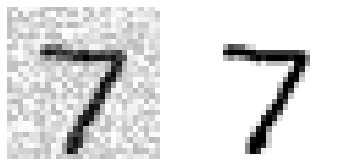

In [55]:
# noise가 섞인 이미지 데이터
some_index = 0
plt.subplot(121); plot_digit(X_test_mod.to_numpy()[some_index])
plt.subplot(122); plot_digit(y_test_mod.to_numpy()[some_index])
plt.show()

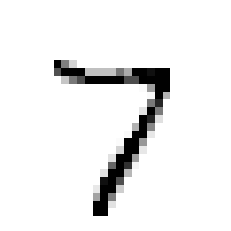

In [56]:
# 분류기를 훈련시켜 이미지 꺠끗하게 만들기
some_index=0
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.to_numpy()[some_index]])
plot_digit(clean_digit)